In [22]:
from SCreator import FileReader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier as xgb


In [23]:
def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate


In [24]:
def create_base_data(data, dest_data, x_range):
    for i in range(len(data)):
        mini_frame = []
        mini_frame.append(data[i].average_for_samples(x_range[0],x_range[1]))
        part_of_egg = ''.join(filter(lambda x: not x.isdigit(), data[i].samples[0].part_class))
        mini_frame.append(''.join(filter(lambda x: not x.isdigit(), part_of_egg)))
        mini_frame.append(not data[i].samples[0].ill)
        dest_data.append(mini_frame)

@static_vars(area_counter=1)      
def add_another_area(data_white, data_dark, dest_df, x_range):
    area_to_append = []
    for j in range(len(data_white)):
        for i in range(len(data_white[j])):
            area_to_append.append(data_white[j][i].average_for_samples(x_range[0],x_range[1]))
    for j in range(len(data_dark)):
        for i in range(len(data_dark[j])):
            area_to_append.append(data_dark[j][i].average_for_samples(x_range[0],x_range[1])) 
    dest_df["Area_" + str(add_another_area.area_counter)] = pd.DataFrame(area_to_append)
    add_another_area.area_counter +=1

In [25]:
def run_cv(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    
    print("Accuracy: ", accuracy_score(y_test, model_pred))
    print(classification_report(y_test, model_pred))
    return model

def run_gs_fine(c_pow, gamma_pow,x_train_scaled,y_train ):
    c_powers = [pow(2, i) for i in np.arange(c_pow-2, c_pow+2, 0.25)]
    gamma_powers = [pow(2, i) for i in np.arange(gamma_pow-2, gamma_pow+2, 0.25)]
    parameters = {'C': c_powers, 
              'gamma': gamma_powers,
              'kernel': ['rbf']}
    
    grid_svc = GridSearchCV(SVC(), param_grid=parameters, scoring='accuracy')
    grid_svc.fit(x_train_scaled, y_train)
    return grid_svc.best_params_
    
def run_gs(x_train_scaled,y_train):
    c_powers = [pow(2, i) for i in range(-5, 16,2)]
    gamma_powers = [pow(2, i) for i in range(-15, 4,2)]
    parameters = {'C': c_powers, 
              'gamma': gamma_powers,
              'kernel': ['rbf']}
    grid_svc = GridSearchCV(SVC(), param_grid=parameters, scoring='accuracy')
    grid_svc.fit(x_train_scaled, y_train)
    return run_gs_fine(np.log2(grid_svc.best_params_ ['C']), np.log2(grid_svc.best_params_ ['gamma']),x_train_scaled,y_train)

In [26]:
eggs_healthy = []
eggs_ill = []
dir_path_healthy = 'data2k17/Healthy_white/'
dir_path_ill = 'data2k17/ill_white/'
dir_path_healthy_dark = 'data2k17/Healthy_dark/'
dir_path_ill_dark = 'data2k17/ill_dark/'

In [27]:
eggs_healthy = FileReader.FileReader(dir_path_healthy).read_files()
eggs_healthy_dark = FileReader.FileReader(dir_path_healthy_dark).read_files()
eggs_ill = FileReader.FileReader(dir_path_ill).read_files()
eggs_ill_dark = FileReader.FileReader(dir_path_ill_dark).read_files()

In [28]:
data_white = []
data_dark = []
df = pd.DataFrame()
x_range = [640, 650]

In [29]:
create_base_data(eggs_healthy, data_white, x_range)
create_base_data(eggs_ill, data_white, x_range)
create_base_data(eggs_healthy_dark, data_dark, x_range)
create_base_data(eggs_ill_dark, data_dark, x_range)

In [30]:
df_white = pd.DataFrame(data_white, columns = ["Area", "EggPart", "Healthy"])
df_dark = pd.DataFrame(data_dark, columns = ["Area", "EggPart", "Healthy"])

In [31]:
df_white["Color"] = 1
df_dark["Color"] = 0

In [32]:
df = pd.concat([df_white, df_dark])

In [33]:
df.groupby("Color").describe()

Area                                                         \
       count       mean        std        min        25%        50%   
Color                                                                 
0      213.0  28.946952  10.423547   9.836433  21.373207  26.739276   
1      297.0  57.147289   8.849013  36.189377  50.996917  56.868051   

                             
             75%        max  
Color                        
0      35.813959  63.086545  
1      63.580707  76.569794

In [34]:
df.drop(["Healthy"], axis=1, inplace = True)

In [35]:
df.reset_index(drop = True, inplace = True)

In [36]:
part_mapping = {'a' : 1, 'h' : 2, 'z' : 3, 'c' : 4, 'hh' : 5, 'zz' : 6, 'b' : 7}
df["EggPart"] = df["EggPart"].map(part_mapping)

# Step 1 only sick or healthy division

In [37]:
dir_path_healthy = 'data2k17/Healthy_white/'
dir_path_healthy_dark = 'data2k17/Healthy_dark/'
data_white = []
data_dark = []
df = pd.DataFrame()
x_range = [640, 650]

In [38]:
eggs_healthy = FileReader.FileReader(dir_path_healthy).read_files()
eggs_healthy_dark = FileReader.FileReader(dir_path_healthy_dark).read_files()
create_base_data(eggs_healthy, data_white, x_range)
create_base_data(eggs_healthy_dark, data_dark, x_range)

In [39]:
df_white = pd.DataFrame(data_white, columns = ["Area", "EggPart", "Healthy"])
df_dark = pd.DataFrame(data_dark, columns = ["Area", "EggPart", "Healthy"])
df_white["Color"] = 1
df_dark["Color"] = 0
df = pd.concat([df_white, df_dark])
df.drop(["Healthy"], axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
part_mapping = {'a' : 1, 'h' : 2, 'z' : 3, 'c' : 4, 'hh' : 5, 'zz' : 6, 'b' : 7}
df["EggPart"] = df["EggPart"].map(part_mapping)

In [40]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [41]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        20

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



# Step 2 without the division

In [42]:
eggs_healthy = []
eggs_healthy_dark = []
eggs_ill = []
eggs_ill_dark = []
dir_path_healthy = 'data2k17/Healthy_white/'
dir_path_ill = 'data2k17/ill_white/'
dir_path_healthy_dark = 'data2k17/Healthy_dark/'
dir_path_ill_dark = 'data2k17/ill_dark/'

In [43]:
eggs_healthy = FileReader.FileReader(dir_path_healthy).read_files()
eggs_healthy_dark = FileReader.FileReader(dir_path_healthy_dark).read_files()
eggs_ill = FileReader.FileReader(dir_path_ill).read_files()
eggs_ill_dark = FileReader.FileReader(dir_path_ill_dark).read_files()

In [44]:
data_white = []
data_dark = []
df = pd.DataFrame()
x_range = [640, 650]

In [45]:
create_base_data(eggs_healthy, data_white, x_range)
create_base_data(eggs_ill, data_white, x_range)
create_base_data(eggs_healthy_dark, data_dark, x_range)
create_base_data(eggs_ill_dark, data_dark, x_range)

In [46]:
df_white = pd.DataFrame(data_white, columns = ["Area", "EggPart", "Healthy"])
df_dark = pd.DataFrame(data_dark, columns = ["Area", "EggPart", "Healthy"])
df_white["Color"] = 1
df_dark["Color"] = 0
df = pd.concat([df_white, df_dark])
df.drop(["Healthy"], axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
part_mapping = {'a' : 1, 'h' : 2, 'z' : 3, 'c' : 4, 'hh' : 5, 'zz' : 6, 'b' : 7}
df["EggPart"] = df["EggPart"].map(part_mapping)

In [47]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [48]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9215686274509803
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        44
           1       0.88      1.00      0.94        58

    accuracy                           0.92       102
   macro avg       0.94      0.91      0.92       102
weighted avg       0.93      0.92      0.92       102



In [49]:
mxgb = xgb(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.3, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =2, nthread = -1)

In [51]:
mxg = run_cv(mxgb, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9313725490196079
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        44
           1       0.89      1.00      0.94        58

    accuracy                           0.93       102
   macro avg       0.95      0.92      0.93       102
weighted avg       0.94      0.93      0.93       102



### adding another area


In [52]:
add_another_area([eggs_healthy, eggs_ill], [eggs_healthy_dark, eggs_ill_dark], df, [520, 540])

In [53]:
df.groupby("Color").describe()

Area                                                         \
       count       mean        std        min        25%        50%   
Color                                                                 
0      213.0  28.946952  10.423547   9.836433  21.373207  26.739276   
1      297.0  57.147289   8.849013  36.189377  50.996917  56.868051   

                            EggPart            ...           Area_1  \
             75%        max   count      mean  ...  75%  max  count   
Color                                          ...                    
0      35.813959  63.086545   213.0  3.502347  ...  4.0  7.0  213.0   
1      63.580707  76.569794   297.0  3.380471  ...  4.0  7.0  297.0   

                                                                         \
            mean        std        min        25%        50%        75%   
Color                                                                     
0       8.104326   5.848968   1.195959   3.912728   6.148381  10.487539   
1      38.993289  10.657778  13.352884  30.928805  39.505652  47.222955   

                  
             max  
Color             
0      33.450559  
1      65.083870  

[2 rows x 24 columns]

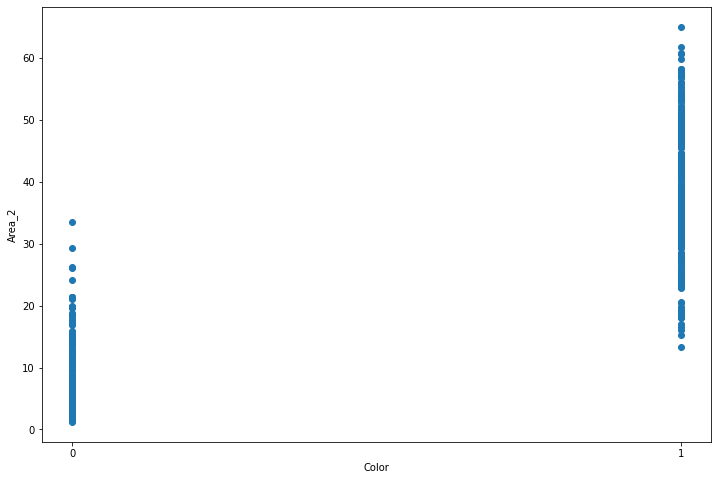

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df['Color'], df['Area_1'])
ax.set_xlabel('Color')
ax.set_ylabel('Area_2')
ax.xaxis.set_ticks(np.arange(0, 1.1, 1))
fig.savefig('imgs/with-outliers.png' , dpi=700)
plt.show()

In [55]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [56]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9607843137254902
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.95      0.98      0.97        58

    accuracy                           0.96       102
   macro avg       0.96      0.96      0.96       102
weighted avg       0.96      0.96      0.96       102



In [57]:
mxgb = xgb(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.01, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.3, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =2, nthread = -1)
mxg = run_cv(mxgb, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9509803921568627
              precision    recall  f1-score   support

           0       0.98      0.91      0.94        44
           1       0.93      0.98      0.96        58

    accuracy                           0.95       102
   macro avg       0.96      0.95      0.95       102
weighted avg       0.95      0.95      0.95       102



In [62]:
df

,Area,EggPart,Color,Area_1
0,63.441723,7,1,53.306169
1,73.982743,4,1,59.906496
2,65.256158,1,1,50.073311
3,62.559203,7,1,47.380140
4,59.058978,7,1,43.761628
...,...,...,...,...
505,20.555409,1,0,3.791673
506,21.373207,4,0,3.636574
507,25.309519,2,0,4.579019
508,21.289893,6,0,3.912728


## w/o outliers

In [ ]:
#przed
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df['Color'], df['Area_4'])
ax.set_xlabel('Color')
ax.set_ylabel('Area_4')
ax.xaxis.set_ticks(np.arange(0, 1.1, 1))
plt.show()

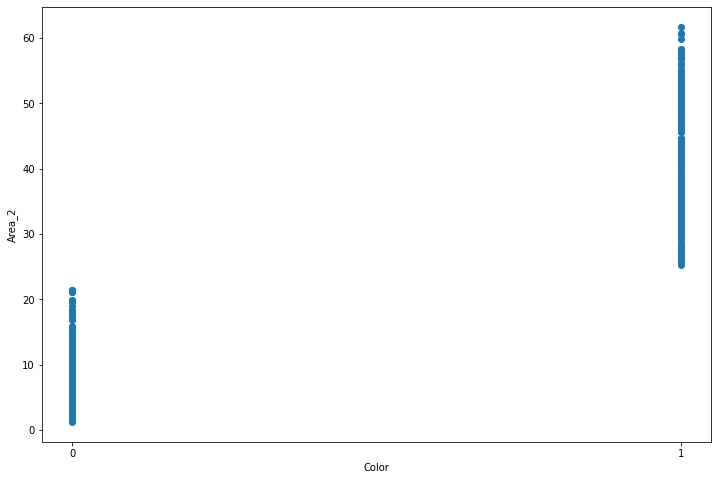

In [71]:
#po
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df_out['Color'], df_out['Area_1'])
ax.set_xlabel('Color')
ax.set_ylabel('Area_2')
ax.xaxis.set_ticks(np.arange(0, 1.1, 1))
fig.savefig('imgs/without-outliers.png' , dpi=700)
plt.show()

In [59]:
df.groupby("Color").describe()

Area                                                         \
       count       mean        std        min        25%        50%   
Color                                                                 
0      213.0  28.946952  10.423547   9.836433  21.373207  26.739276   
1      297.0  57.147289   8.849013  36.189377  50.996917  56.868051   

                            EggPart            ...           Area_1  \
             75%        max   count      mean  ...  75%  max  count   
Color                                          ...                    
0      35.813959  63.086545   213.0  3.502347  ...  4.0  7.0  213.0   
1      63.580707  76.569794   297.0  3.380471  ...  4.0  7.0  297.0   

                                                                         \
            mean        std        min        25%        50%        75%   
Color                                                                     
0       8.104326   5.848968   1.195959   3.912728   6.148381  10.487539   
1      38.993289  10.657778  13.352884  30.928805  39.505652  47.222955   

                  
             max  
Color             
0      33.450559  
1      65.083870  

[2 rows x 24 columns]

In [70]:
#df_outliers = df[((df["Color"] == 1) & (df["Area"] < 60)) | ((df["Color"] == 0) & (df["Area"] > 60))]
df_outliers = df[((df["Color"] == 1) & (df["Area_1"] < 25)) | ((df["Color"] == 0) & (df["Area_1"] > 23)) | ((df["Color"] == 1) & (df["Area_1"] > 62))]
df_out = df.drop(df_outliers.index, axis=0)

In [64]:
x = df_out.drop('Color', axis=1)
y = df_out['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [65]:
#no i kozak wynik jutro opisac
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      1.00      1.00        51

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95



## Split it

In [254]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [255]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [256]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.8689655172413793
Log loss:  4.52580930127803
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        54
           1       0.92      0.87      0.89        91

    accuracy                           0.87       145
   macro avg       0.86      0.87      0.86       145
weighted avg       0.87      0.87      0.87       145



In [257]:
rf = RandomForestClassifier(n_estimators=1000)
rf = run_cv(rf, x_train, y_train, x_test, y_test)

Accuracy:  0.8689655172413793
Log loss:  4.525803786812995
              precision    recall  f1-score   support

           0       0.79      0.89      0.83        54
           1       0.93      0.86      0.89        91

    accuracy                           0.87       145
   macro avg       0.86      0.87      0.86       145
weighted avg       0.88      0.87      0.87       145



## Adding another area according to the extracted spectra graphs


In [199]:
add_another_area([eggs_healthy, eggs_healthy_dark], [eggs_ill, eggs_ill_dark], df, [580, 600])

In [200]:
df.describe()

,Area,EggPart,Color,Area_2
count,510.000000,510.000000,510.000000,510.000000
mean,45.369501,3.431373,0.582353,67.223546
std,16.869837,2.053842,0.493656,33.833172
min,9.836433,1.000000,0.000000,7.689159
25%,29.420078,2.000000,0.000000,32.673253
50%,47.835297,3.000000,1.000000,73.800404
75%,58.736923,4.000000,1.000000,95.525269
max,76.569794,7.000000,1.000000,129.490010


In [201]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [202]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [203]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9901960784313726
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        44
           1       0.98      1.00      0.99        58

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



In [308]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=7)
rf = run_cv(rf, x_train, y_train, x_test, y_test)

Accuracy:  0.9803921568627451
Log loss:  0.677238748894624
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.98      0.98      0.98        58

    accuracy                           0.98       102
   macro avg       0.98      0.98      0.98       102
weighted avg       0.98      0.98      0.98       102



## w/o outliers

In [204]:
add_another_area([eggs_healthy, eggs_healthy_dark], [eggs_ill, eggs_ill_dark], df, [520, 540])

In [74]:
add_another_area([eggs_healthy, eggs_healthy_dark], [eggs_ill, eggs_ill_dark], df, [580, 600])

### IQR

In [205]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_out = df[~(((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))).any(axis=1)]
df_out.shape

(510, 5)

In [206]:
x = df_out.drop('Color', axis=1)
y = df_out['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [207]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9705882352941176
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        44
           1       0.98      0.97      0.97        58

    accuracy                           0.97       102
   macro avg       0.97      0.97      0.97       102
weighted avg       0.97      0.97      0.97       102



In [78]:
df

,Area,EggPart,Color,Area_2,Area_3,Area_4
0,44.193510,1,1,53.306169,109.062248,109.062248
1,55.270944,2,1,59.906496,124.930121,124.930121
2,46.408355,3,1,50.073311,108.998798,108.998798
3,38.895401,1,1,47.380140,104.159126,104.159126
4,45.751133,4,1,43.761628,97.037961,97.037961
...,...,...,...,...,...,...
505,20.555409,1,0,6.148381,19.800262,19.800262
506,21.373207,4,0,7.827639,19.664886,19.664886
507,25.309519,2,0,6.541322,24.065905,24.065905
508,21.289893,6,0,22.884198,20.290746,20.290746


### z-score

In [79]:
z = np.abs(stats.zscore(df))
df_out = df[(z < 2.1).all(axis=1)]
df_out.shape

(509, 6)

In [80]:
x = df_out.drop('Color', axis=1)
y = df_out['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [81]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9901960784313726
Log loss:  0.33861545485206646
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       1.00      0.98      0.99        60

    accuracy                           0.99       102
   macro avg       0.99      0.99      0.99       102
weighted avg       0.99      0.99      0.99       102



### manual

In [325]:
df_outliers = df[((df["Color"] == 1) & (df["Area"] < 60)) | ((df["Color"] == 0) & (df["Area"] > 60))]
df_out = df.drop(df_outliers.index, axis=0)

In [134]:
df_out.describe()

,Area,EggPart,Color,Area_1,Area_mean_distance,Area_mean_distance_1
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,45.707991,2.546599,0.581864,24.840773,13.238485,15.950178
std,16.013322,1.221015,0.493875,17.721848,8.640522,7.494389
min,11.822342,1.000000,0.000000,1.480404,0.070227,0.054115
25%,32.051361,1.000000,0.000000,6.813446,5.309169,10.274908
50%,47.666137,3.000000,1.000000,23.675583,12.508472,17.339273
75%,57.922750,4.000000,1.000000,41.223497,20.287995,21.638899
max,76.569794,5.000000,1.000000,58.049481,31.521312,31.216928


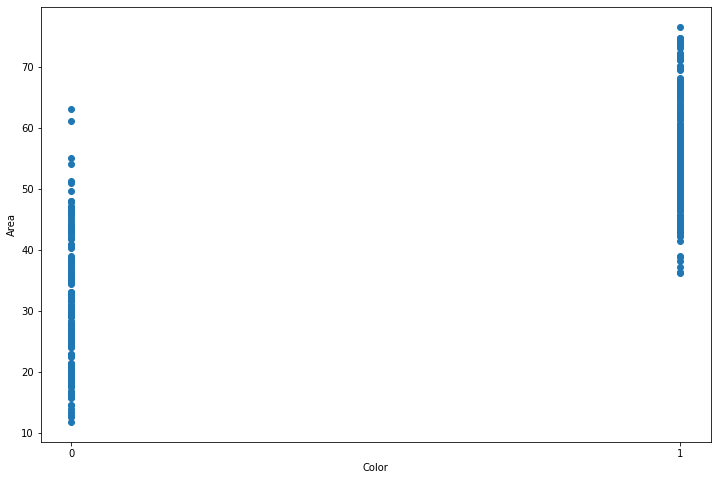

In [133]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(df_out['Color'], df_out['Area'])
ax.set_xlabel('Color')
ax.set_ylabel('Area')
ax.xaxis.set_ticks(np.arange(0, 1.1, 1))
plt.show()

In [328]:
x = df_out.drop('Color', axis=1)
y = df_out['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=44)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [329]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])

In [330]:
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  1.0
Log loss:  9.992007221626413e-16
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        57

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94



### adding distance from the mean for each parameter


In [116]:
#add_another_area([eggs_healthy, eggs_healthy_dark], [eggs_ill, eggs_ill_dark], df, [580, 600])
add_another_area([eggs_healthy, eggs_healthy_dark], [eggs_ill, eggs_ill_dark], df, [520, 540])

In [117]:
df = df.join(df.groupby("EggPart").agg(np.mean), on='EggPart', rsuffix='_mean')
df["Area_mean_distance"] = abs(df["Area"] - df["Area_mean"])
df["Area_mean_distance_1"] = abs(df["Area_1"] - df["Area_1_mean"])
df["Area_mean_distance_2"] = abs(df["Area_2"] - df["Area_2_mean"])

col_to_drop = ["Area_mean", "Area_1_mean", "Area_2_mean" , "Color_mean"]
df.drop(col_to_drop, axis = 1, inplace = True)

In [123]:
x = df.drop('Color', axis=1)
y = df['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [124]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9607843137254902
Log loss:  1.3544931761702315
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        70
           1       0.93      1.00      0.97        83

    accuracy                           0.96       153
   macro avg       0.97      0.96      0.96       153
weighted avg       0.96      0.96      0.96       153



In [120]:
df

,Area,EggPart,Color,Area_1,Area_mean_distance,Area_mean_distance_1
0,44.193510,1,1,53.306169,1.410269,26.081918
1,55.270944,2,1,59.906496,6.169148,34.932618
2,46.408355,3,1,50.073311,0.751502,26.061441
3,38.895401,1,1,47.380140,3.887840,20.155889
4,45.751133,4,1,43.761628,0.233167,17.921498
...,...,...,...,...,...,...
505,20.555409,1,0,3.791673,22.227832,23.432578
506,21.373207,4,0,3.636574,24.144759,22.203556
507,25.309519,2,0,4.579019,23.792277,20.394858
508,21.289893,6,0,3.912728,13.638886,8.666951


In [128]:
df_out.shape

(510, 6)

In [131]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_out = df[~(((df < (Q1 - 0.75 * IQR)) | (df > (Q3 + 0.75 * IQR)))).any(axis=1)]
x = df_out.drop('Color', axis=1)
y = df_out['Color']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
sc = StandardScaler()
x_train_scaled, x_test_scaled = sc.fit_transform(x_train), sc.fit_transform(x_test)

In [132]:
gs_params = run_gs(x_train_scaled, y_train)
svc = SVC(C=gs_params["C"], gamma= gs_params["gamma"])
svc = run_cv(svc, x_train_scaled, y_train, x_test_scaled, y_test)

Accuracy:  0.9875
Log loss:  0.43173470493638455
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        48

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

